### 6.1 Overview

Clustering is a type of unsupervised learning that allows us to find groups of similar objects, objects that are more related to each other than to the objects in other groups. This is often used when we don’t have access to the ground truth, in other words, the labels are missing.

Examples of business use cases include the grouping of documents, music, and movies based on their contents, or finding customer segments based on purchase behavior as a basis for recommendation engines.
The goal of clustering is to separate the data into groups, or clusters, with more similar traits to each other than to the data in the other clusters.

#### Different Types of Clustering Algorithms

There are more than 100 clustering algorithms known, 12 of them have been implemented in scikit-learn, but few gained popularity.

In general, there are four types:

**Centroid based** models - each cluster is represented by a single mean vector (e.g., k-means),

**Connectivity based** models - built based on distance connectivity (e.g., hierarchical clustering)

**Distribution based** models - built using statistical distributions (e.g., Gaussian mixtures)

**Density based** models - clusters are defined as dense areas (e.g., DBSCAN)

In this module, we will explore the simple and widely-used clustering algorithm, k-means, to reveal subgroups of wines based on the chemical analysis reports.

### 6.2 K-means

One of the most popular clustering algorithms is k-means. Assuming that there are n data points, the algorithm works as follows:

Step 1: initialization - pick k random points as cluster centers, called centroids

Step 2: cluster assignment - assign each data point to its nearest centroid based on its distance to each centroid, and that forms k clusters

Step 3: centroid updating - for each new cluster, calculate its centroid by taking the average of all the points assigned to the cluster

Step 4: repeat steps 2 and 3 until none of cluster assignments change, or it reaches the maximum number of iterations

The k-means algorithm has been implemented in module sklearn.cluster, to access it:

from sklearn.cluster import KMeans

#### Distance Metric

How do we calculate the distance in k-means algorithm? One way is the euclidean distance, a straight line between two data points as shown below.

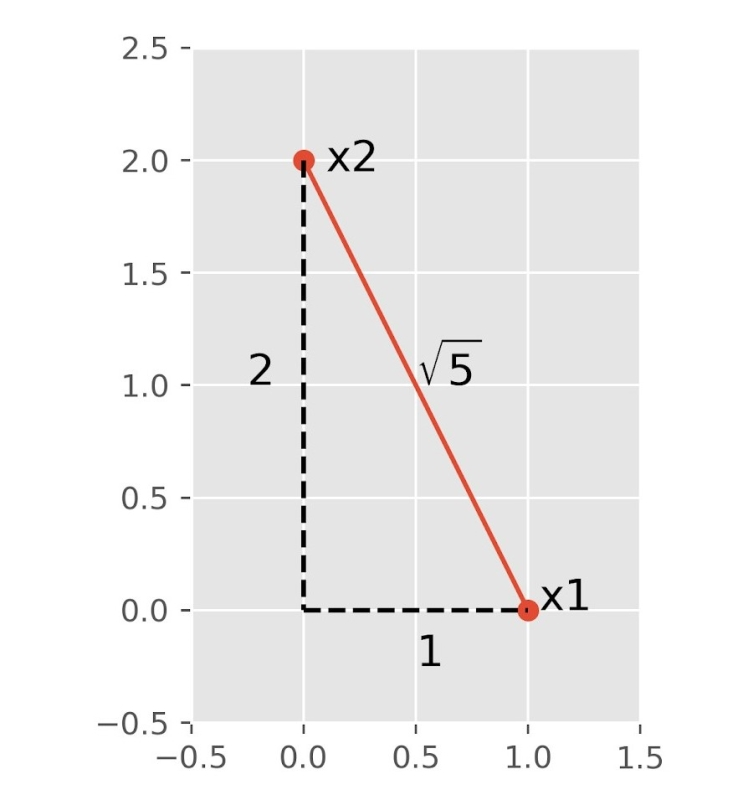

For example, the euclidean distance between points x1 = (0, 1) and x2 = (2, 0) are given by:

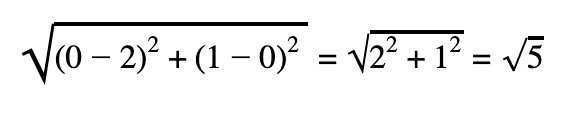

In [2]:
#Or in numpy we can calculate the distance as follows:

import numpy as np
x1 = np.array([0, 1])
x2 = np.array([2, 0])
print(np.sqrt(((x1-x2)**2).sum()))
# 2.23606797749979
print(np.sqrt(5))
# 2.23606797749979

2.23606797749979
2.23606797749979


### 6.3 Wine Data

In this module, we analyze the result of a chemical analysis of wines grown in a particular region in Italy. And the goal is to try to group similar observations together and determine the number of possible clusters. This would help us make predictions and reduce dimensionality. As we will see there are 13 features for each wine, and if we could group all the wines into, say 3 groups, then it is reducing the 13-dimensional space to a 3-dimensional space. More specifically we can represent each of our original data points in terms of how far it is from each of these three cluster centers.

The analysis reported the quantities of 13 constituents from 178 wines: alcohol, malic acid, ash, alcalinity of ash, magnesium, total phenols, flavanoids, nonflavanoid phenols, proanthocyanins, color intensity, hue, od280/od315 of diluted wines, and proline.

The data is loaded in a dataframe 'wine'

In [3]:

from sklearn.datasets import load_wine
load_wine = load_wine()
import pandas as pd
wine = pd.DataFrame(load_wine.data, columns=load_wine.feature_names)
wine['group'] = load_wine.target



In [7]:
wine.head()

#For the ease of display, we show the basic statistics of the first 3 features:
wine.iloc[:,:3].describe()

# There are no missing values. It is worth noting that the attributes are not on the same scale. 
# We will have to scale the data later.


#Another way to check for column names and the datatype of each column is to use .info().

,alcohol,malic_acid,ash
count,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517
std,0.811827,1.117146,0.274344
min,11.030000,0.740000,1.360000
25%,12.362500,1.602500,2.210000
50%,13.050000,1.865000,2.360000
75%,13.677500,3.082500,2.557500
max,14.830000,5.800000,3.230000


#### Plotting the Data

The summary statistics provide some of the information, while visualization offers a more direct view showing the distribution and the relationship between features.

Here we introduce a plotting function to display histograms along the diagonal and the scatter plots for every pair of attributes off the diagonal, 'scatter_matrix', for the ease of display, let’s show just two features:

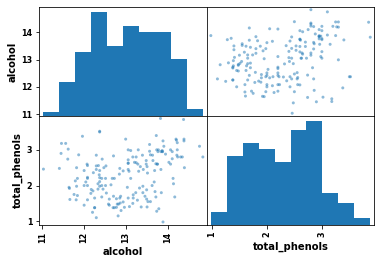

In [8]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
scatter_matrix(wine.iloc[:,[0,5]])
plt.show()

As we don’t know the ground truth, we look into the scatter plots to come up with a reasonable candidate for k, the number of clusters. There seem to be roughly three subgroups. Remember that there are no right or wrong answers for the number of subgroups. In the real world data, rarely do we find clear clusters; but we come up with our best educated guess. For example, in the scatter plot above, there seem to be three subgroups.

#### Pre-processing: Standardization

After examining all the pairs of scatter plot, we pick two features to better illustrate the algorithm: alcohol and total_phenols, whose scatterplot also suggests three subclusters.

X = wine[['alcohol', 'total_phenols']]

Unlike any supervised learning models, in general, unsupervised machine learning models do not require to split data into training and testing sets since there is no ground truth to validate the model. However, centroid-based algorithms require one pre-processing step because k-means works better on data where each attribute is of similar scales. One way to achieve this is to standardize the data; mathematically:

z = (x - mean) / std

where x is the raw data, mean and std are the average and standard deviation of x, and z is the scaled x such that it is centered at 0 and it has a unit standard deviation. StandardScaler under the sklearn.preprocessing makes it easy:

In [13]:
from sklearn.preprocessing import StandardScaler

X = wine[['alcohol', 'total_phenols']]

# instantiate the scaler
scale = StandardScaler()

# compute the mean and std to be used later for scaling
scale.fit(X)
# StandardScaler(copy=True, with_mean=True, with_std=True)

#We can look into the object scale, extract the calculated mean and std:

print(scale.mean_)
# array([13.00061798,  2.29511236])

print(scale.scale_)
# array([0.80954291, 0.62409056])

#The raw alcohol measurements have a mean 13.00 and std 0.81 while total phenols are centered at 2.29 with a std 0.62.
# Next we can fit to the training data, and transform it.
X_scaled = scale.transform(X)



[13.00061798  2.29511236]
[0.80954291 0.62409056]


We show the original (blue) and scaled (orange) data in the plot to visualize the effect of scaling. After scaling, the data is centered around (0, 0), and the ranges along x- and y-axis are roughly the same, from -2.5 to 2.5.

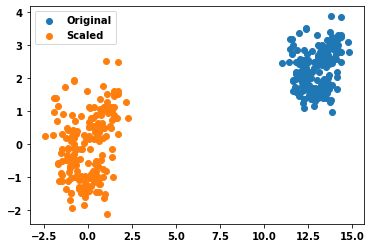

In [23]:
plt.scatter(X.iloc[:,0],X.iloc[:,1],label='Original')
plt.scatter(X_scaled[:,0],X_scaled[:,1],label='Scaled')
plt.legend()
plt.show()

In [25]:
#Let’s do a sanity check to see if each feature is centered at 0 and has a std of 1:

print(X_scaled.mean(axis=0))
# array([ 7.84141790e-15, -1.95536471e-16])

print(X_scaled.std(axis=0))
# array([1., 1.])

[ 7.84141790e-15 -1.95536471e-16]
[1. 1.]


### K-means Modeling

Just like linear regression and k nearest neighbours, or any machine learning algorithms in scikit-learn, to do the modeling, we follow instantiate / fit / predict workflow. There are other arguments in KMeans, such as method to initialize the centroids, stopping criteria, etc., yet we focus on the number of clusters, n_clusters, and allow other parameters to take the default values. Here we specify 3 clusters:

In [26]:
from sklearn.cluster import KMeans

# instantiate the model
kmeans = KMeans(n_clusters=3)

# fit the model
kmeans.fit(X_scaled)

# make predictions
y_pred = kmeans.predict(X_scaled)
print(y_pred)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 2 0 0 0 1 0 1 0 2 1 2 1
 0 0 2 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 2 0 0 0 2 2 2 0 0 0
 0 0 0 0 0 0 0 2 0 0 0 0 1 0 0 0 0 0 0 2 2 2 2 0 2 2 2 2 0 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 0 1 1 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1]


In [27]:
#There are 60 wines in cluster 0, 65 in cluster 1, and 53 in cluster 2.

#To inspect the coordinates of the three centroids:
kmeans.cluster_centers_

array([[-1.06309124,  0.06418028],
       [ 0.92017418,  0.87087204],
       [ 0.07498401, -1.14070754]])

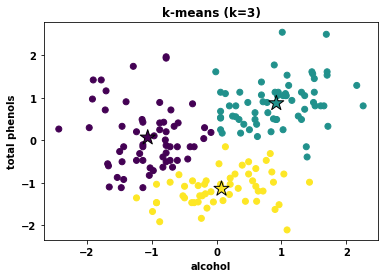

In [28]:
# A better way to see the results is to visualize them:


import matplotlib.pyplot as plt
# plot the scaled data
plt.scatter(X_scaled[:,0], 
            X_scaled[:,1],
            c= y_pred)
# identify the centroids
plt.scatter(kmeans.cluster_centers_[:, 0],
            kmeans.cluster_centers_[:, 1], 
            marker="*",
            s = 250, 
            c = [0,1,2], 
            edgecolors='k')
plt.xlabel('alcohol'); plt.ylabel('total phenols')
plt.title('k-means (k=3)')
plt.show()

The stars are the centroids. K-means divides wines into three groups: low alcohol but high total phenols (upper right in green), high alcohol and high total phenols (upper left in yellow), and low total phenols (bottom in purple). For any new wine with the chemical report on alcohol and total phenols, we now can classify it based on its distance to each of the centroids. Suppose that there is new wine with alcohol at 13 and total phenols at 2.5, let’s predict which cluster the model will assign the new wine to.

In [29]:
# to predict the cluster for out of sample data

# First we need to put the new data into a 2d array:
X_new = np.array([[13, 2.5]])

#Next, we need to standardize the new data:
X_new_scaled = scale.transform(X_new)
print(X_new_scaled)
# [[-0.00076337  0.32829793]]

#Now we are ready to predict the cluster:
kmeans.predict(X_new_scaled)
# [1]

[[-0.00076337  0.32829793]]


array([1])

One major shortcoming of k-means is that the random initial guess for the centroids can result in bad clustering, and k-means++ algorithm addresses this obstacle by specifying a procedure to initialize the centroids before proceeding with the standard k-means algorithm. In scikit-learn, the initialization mechanism is set to k-means++, by default.

#### Optimal k: The Elbow Method

Can we divide the wines into two subgroups? 2 or 4

Sure! As shown, k-means will be happy to divide the dataset into any integer number of clusters, ranging from 1, an extreme case where all data points belong to one big cluster, to n, another extreme case where each data point is its own cluster.

So which one should we choose, 2, or 3, or 4 for the wines?

Intuitively, k-means problem partitions n data points into k tight sets such that the data points are closer to each other than to the data points in the other clusters. And the tightness can be measured as the sum of squares of the distance from data point to its nearest centroid, or inertia.

In scikit-learn, it is stored as inertia_, e.g. when k = 2, the distortion is 185:

In [32]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_scaled)
kmeans.inertia_
# 185.25081541190127

185.25081541190127

In [33]:
# Or when k is 3, the distortion decreases to 114.
kmeans = KMeans(n_clusters=3)
kmeans.fit(X_scaled)
kmeans.inertia_
# 114.34674038310786

114.34674038310783

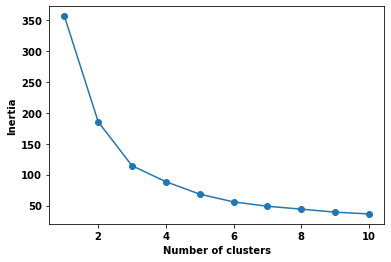

In [34]:
#We plot the inertia for different values of k:

import numpy as np
# calculate distortion for a range of number of cluster
inertia = []
for i in np.arange(1, 11):
    km = KMeans(
        n_clusters=i
    )
    km.fit(X_scaled)
    inertia.append(km.inertia_)

# plot
plt.plot(np.arange(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

As the plot shows, the inertia decreases as the number of clusters increases. The optimal k should be where the inertia no longer decreases as rapidly.

For example, k=3 seems to be optimal, as we increase the number of clusters from 3 to 4, the decrease in inertia slows down significantly, compared to that from 2 to 3. This approach is called elbow method (can you see why?). It is a useful graphical tool to estimate the optimal k in k-means.

One single inertia alone is not suitable to determine the optimal k because the larger k is, the lower the inertia will be.

#### Modeling With More Features

Previously to build kmeans models, we used two (out of thirteen) features: alcohol and total phenols. The choice is random and it is easy to visualize the results. However, can we use more features, for example all of them? Why not? Let’s try it.


In [35]:
X = wine

# Don’t forget to standardize each feature.
scale = StandardScaler() 
scale.fit(X)
X_scaled = scale.transform(X)

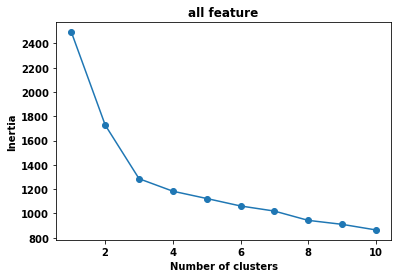

In [36]:
inertia = [] 
for i in np.arange(1, 11):
    km = KMeans(
        n_clusters=i 
        )
    km.fit(X_scaled) 
    inertia.append(km.inertia_)
plt.plot(np.arange(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title("all feature")
plt.show()

In [37]:
# Similarly we spot that the inertia no longer decreases as rapidly after k = 3. 
# We then finalize the model by setting n_clusters = 3 and obtain the predictions.

k_opt = 3
kmeans = KMeans(k_opt)
kmeans.fit(X_scaled)
y_pred = kmeans.predict(X_scaled)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0
 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Compared to the predictions using only two features, the two models produce very similar results. For instance, the first 21 wines are predicted to belong to the same cluster from both models, so are the last 19 wines. In fact, only 13 out of 178 wines were clustered differently by the two models.

It is natural to ask, which model is better? Recall that clustering is an unsupervised learning method, which indicates that we don’t know the ground truth of the labels. Thus it is difficult, if not impossible, to determine that the model with 2 features is more accurate in grouping wines than the one with all 13 features, or vice versa.

Which model, in other words which features, should you choose is often determined by external information. For example, the marketing department wants to know if a continent-specific strategy is needed to sell these wines. We now have access to consumers' demographic information and the three clusters identified from model A correspond better to customers in Europe, Asia, and North America respectively than model B; then model A is the winner. It is an oversimplified example, but you get the gist.

### Extra Info

Keep in mind that  beside using 2 method fit and transform separately , we can use combining method fit_transform(), 
in this lesson : X_scaled=scale.fit_transform(X)